# Libraries

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import random
import os 
import pandas as pd
from collections import deque

# LSGA

In [7]:
class LSGA:
    def __init__(self, sudoku_puzzle, experiment_id, puzzle_id, run_id,output_folder, pop_size=150, elite_size=50, max_generations=10000, pc1=0.2, pc2=0.1, pm1=0.3, pm2=0.05, tournament_size=2):
        # initialize class attributes
        self.sudoku_puzzle = np.array(sudoku_puzzle)  # input sudoku puzzle
        self.experiment_id = experiment_id  # experiment identifier
        self.puzzle_id = puzzle_id  # puzzle identifier
        self.run_id = run_id  # run identifier
        self.history = {'best': [], 'worst': [], 'mean': []}  # to store fitness history
        self.pop_size = pop_size  # population size
        self.elite_size = elite_size  # elite population size
        self.max_generations = max_generations  # maximum number of generations
        self.pc1 = pc1  # individual crossover rate
        self.pc2 = pc2  # row crossover rate
        self.pm1 = pm1  # swap mutation rate
        self.pm2 = pm2  # reinitialization mutation rate
        self.tournament_size = tournament_size  # tournament size for selection
        self.population = []  # main population
        self.elite_population = deque(maxlen=elite_size)  # elite population using deque with maxlen
        self.initialize_population()  # initialize the population

        self.output_folder = output_folder  # output folder for results

        # create output folder if it doesn't exist
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)

    def create_associated_matrix(self, sudoku_puzzle):
        # create a matrix indicating given numbers in the puzzle
        return np.where(sudoku_puzzle != 0, 1, 0)

    def initialize_population(self):
        # initialize the population with individuals
        print("Initializing population...")
        for _ in range(self.pop_size):
            individual = self.init_individual(self.sudoku_puzzle)  # initialize individual 
            associated_matrix = self.create_associated_matrix(self.sudoku_puzzle)  # create associated matrix
            self.population.append((individual, associated_matrix))  # append to population
        print("Population initialized.")

    def init_individual(self, sudoku_puzzle):
        # create a new individual by filling the puzzle randomly
        individual = sudoku_puzzle.copy()  # copy the original puzzle
        for i in range(9):
            self.init_row(individual, i)  # initialize each row
        return individual

    def init_row(self, individual, row_index):
        # initialize a row of the individual by filling missing numbers
        row = individual[row_index]
        missing_numbers = list(set(range(1, 10)) - set(row))  # find missing numbers
        random.shuffle(missing_numbers)  # shuffle missing numbers
        for j in range(9):
            if row[j] == 0:
                row[j] = missing_numbers.pop()  # fill missing numbers randomly

    def fitness(self, chromosome):
        # calculate the fitness of an individual
        individual, _ = chromosome 

        # calculate fitness based on the number of unique numbers in each column and sub-block
        ci = sum(len(set(individual[:, i])) != 9 for i in range(9)) 
        sj = sum(len(set(individual[i:i+3, j:j+3].flatten())) != 9 for i in range(0, 9, 3) for j in range(0, 9, 3))
        return (ci + sj)  # lower fitness is better

    def selection(self):
        # select the best individual from a random sample of the population using tournament selection
        selected = random.sample(self.population, self.tournament_size)
        return min(selected, key=self.fitness)

    def crossover(self, population):
        # perform crossover operation to generate new population
        new_population = []
        for individual in population:
            if random.random() < self.pc1:
                parent1 = individual
                parent2 = random.choice(population)
                child1, child2 = parent1[0].copy(), parent2[0].copy()  # create copies for children
                associated_matrix = parent1[1]
                for i in range(9):
                    if random.random() < self.pc2:
                        # Swap rows i between child1 and child2
                        for j in range(9):
                            if associated_matrix[i][j] == 0:  # Only swap if it's not a given number
                                child1[i][j], child2[i][j] = child2[i][j], child1[i][j]

                new_population.append((child1, associated_matrix))
                new_population.append((child2, associated_matrix))
            else:
                new_population.append(individual)
        return new_population

    def mutation(self, chromosome):
        # perform mutation operations on the individual
        individual, associated_matrix = chromosome
        for i in range(9):
            # Swap mutation
            if random.random() < self.pm1:
                non_given_indices = [j for j in range(9) if associated_matrix[i, j] == 0]
                if len(non_given_indices) >= 2:
                    idx1, idx2 = random.sample(non_given_indices, 2)
                    individual[i][idx1], individual[i][idx2] = individual[i][idx2], individual[i][idx1]

            # Reinitialize mutation
            if random.random() < self.pm2:
                row = individual[i]
                non_given_indices = [j for j in range(9) if associated_matrix[i, j] == 0]
                values = [row[j] for j in non_given_indices]
                random.shuffle(values)  # shuffle values
                for j, value in zip(non_given_indices, values):
                    row[j] = value

        return individual, associated_matrix

    def column_local_search(self, chromosome):
        # perform column-based local search to remove duplicates in columns
        individual, associated_matrix = chromosome
        repeat_marks = self.mark_repeats(individual)  # mark repeated numbers in columns
        C = self.get_illegal_columns(repeat_marks)  # get illegal columns

        illegal_columns = list(C)  # convert set to list
        for i in range(len(illegal_columns)):
            for j in range(i + 1, len(illegal_columns)):
                col1, col2 = illegal_columns[i], illegal_columns[j]
                for row in range(9):
                    # check if both columns have repeated numbers in the same row
                    if repeat_marks[row][col1] == 1 and repeat_marks[row][col2] == 1:
                        # ensure the positions are not given numbers
                        if associated_matrix[row][col1] == 0 and associated_matrix[row][col2] == 0:
                            # swap the values in the row
                            individual[row][col1], individual[row][col2] = individual[row][col2], individual[row][col1]
        return individual, associated_matrix

    def sub_block_local_search(self, chromosome):
        # perform sub-block-based local search to remove duplicates in sub-blocks
        individual, associated_matrix = chromosome
        repeat_marks = self.mark_sub_block_repeats(individual)  # mark repeated numbers in sub-blocks
        S = self.get_illegal_sub_blocks(repeat_marks)  # get illegal sub-blocks

        illegal_sub_blocks = list(S)  # convert set to list
        for i in range(len(illegal_sub_blocks)):
            for j in range(i + 1, len(illegal_sub_blocks)):
                sub_block1, sub_block2 = illegal_sub_blocks[i], illegal_sub_blocks[j]
                for row in range(3):
                    row1 = sub_block1[0] * 3 + row  # calculate row index in sub-block 1
                    row2 = sub_block2[0] * 3 + row  # calculate row index in sub-block 2
                    for col in range(3):
                        col1 = sub_block1[1] * 3 + col  # calculate column index in sub-block 1
                        col2 = sub_block2[1] * 3 + col  # calculate column index in sub-block 2
                        # check if both sub-blocks have repeated numbers in the same row and column
                        if repeat_marks[row1][col1] == 1 and repeat_marks[row2][col2] == 1 and row1 == row2:
                            # ensure the positions are not given numbers
                            if associated_matrix[row1][col1] == 0 and associated_matrix[row2][col2] == 0:
                                # swap the values in the same row
                                individual[row1][col1], individual[row2][col2] = individual[row2][col2], individual[row1][col1]
        return individual, associated_matrix

    def mark_repeats(self, individual):
        # mark the repeated numbers in each column
        repeat_marks = np.zeros((9, 9))  # initialize repeat marks matrix with zeros
        for i in range(9):
            col_counts = {}  # dictionary to count occurrences in each column
            for j in range(9):
                num = individual[j][i]
                if num in col_counts:
                    col_counts[num] += 1
                else:
                    col_counts[num] = 1
            for j in range(9):
                if col_counts[individual[j][i]] > 1:  # mark repeated numbers
                    repeat_marks[j][i] = 1
        return repeat_marks

    def mark_sub_block_repeats(self, individual):
        # mark the repeated numbers in each sub-block
        repeat_marks = np.zeros((9, 9))  # initialize repeat marks matrix with zeros
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                sub_block_counts = {}  # dictionary to count occurrences in each sub-block
                for k in range(3):
                    for l in range(3):
                        num = individual[i+k][j+l]
                        if num in sub_block_counts:
                            sub_block_counts[num] += 1
                        else:
                            sub_block_counts[num] = 1
                for k in range(3):
                    for l in range(3):
                        if sub_block_counts[individual[i+k][j+l]] > 1:  # mark repeated numbers
                            repeat_marks[i+k][j+l] = 1
        return repeat_marks

    def get_illegal_columns(self, repeat_marks):
        # get columns that contain duplicates
        illegal_columns = set()  # initialize set for illegal columns
        for j in range(9):
            if sum(repeat_marks[:, j]) > 0:  # check if there are any repeated numbers in the column
                illegal_columns.add(j)
        return illegal_columns

    def get_illegal_sub_blocks(self, repeat_marks):
        # get sub-blocks that contain duplicates
        illegal_sub_blocks = set()  # initialize set for illegal sub-blocks
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                if np.sum(repeat_marks[i:i+3, j:j+3]) > 0:  # check if there are any repeated numbers in the sub-block
                    illegal_sub_blocks.add((i // 3, j // 3))
        return illegal_sub_blocks

    def elite_population_learning(self, new_population):
        # perform elite population learning to maintain diversity and avoid local optima
        worst_individual = sorted(new_population, key=self.fitness)[-1]  # find the worst individual

        # calculate Maxfx
        max_fitness = self.fitness(worst_individual)

        # calculate Pb
        if self.elite_population:
            random_elite = random.choice(self.elite_population)
            fitness_random = self.fitness(random_elite)
            Pb = (max_fitness - fitness_random) / max_fitness if max_fitness != 0 else 0
        else:
            Pb = 0

        # decide whether to replace the worst individual with a random elite or reinitialize
        if random.random() < Pb and self.elite_population:
            new_population[-1] = random.choice(self.elite_population)
        else:
            new_individual = self.init_individual(self.sudoku_puzzle)
            associated_matrix = self.create_associated_matrix(self.sudoku_puzzle)
            new_population[-1] = (new_individual, associated_matrix)
        
        # update the population to maintain pop_size limit
        self.population = sorted(new_population, key=self.fitness)[:self.pop_size]

    def run(self):
        # main function to run the LSGA
        print("Starting LSGA...")
        generation = 1
        best_individual = min(self.population, key=self.fitness)
        best_fitness = self.fitness(best_individual)
        total_generations_to_find_solution = 0

        # run the algorithm for max_generations or until an optimal solution is found
        while generation <= self.max_generations and best_fitness > 0: 
            new_population = [self.selection() for _ in range(self.pop_size)]
            new_population = self.crossover(new_population)
            new_population = [self.mutation(ind) for ind in new_population]
            new_population = [self.column_local_search(ind) for ind in new_population]
            new_population = [self.sub_block_local_search(ind) for ind in new_population]

            self.elite_population_learning(new_population)  # perform elite population learning

            best_individual = min(self.population, key=self.fitness)
            best_fitness = self.fitness(best_individual)

            self.elite_population.append(best_individual)  # add best individual to elite population
            if len(self.elite_population) > self.elite_size:
                self.elite_population.popleft()  # maintain elite population size
            
            # print generation and best fitness
            print(f"Generation {generation}: Best fitness = {best_fitness}")

            # store fitness values in history
            generation_best = best_fitness
            generation_worst = max(self.fitness(ind) for ind in self.population)
            generation_mean = np.mean([self.fitness(ind) for ind in self.population])
            self.history['best'].append(generation_best)
            self.history['worst'].append(generation_worst)
            self.history['mean'].append(generation_mean)

            total_generations_to_find_solution = generation

            generation += 1

            if generation % 10 == 0:
                self.plot_fitness_history()

            if best_fitness == 0:
                break

        print(f"Best solution found with fitness = {best_fitness}")
        self.plot_fitness_history()
        self.plot_sudoku_solution(best_individual[0])
        
        # store history in a DataFrame
        history_df = pd.DataFrame(self.history)

        # save history to Excel file
        output_file = os.path.join(self.output_folder, f'fitness_history_{self.puzzle_id}_{self.run_id}.xlsx')
        history_df.to_excel(output_file, index=False)
 
        return best_individual[0], best_fitness, total_generations_to_find_solution
    
    def plot_fitness_history(self):
        # plot fitness history over generations
        generations = range(1,len(self.history['best'])+1)
        plt.figure(figsize=(6, 3))
        plt.plot(generations, self.history['best'], label='Best Fitness')
        plt.plot(generations, self.history['mean'], label='Mean Fitness')
        plt.plot(generations, self.history['worst'], label='Worst Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title(f'Fitness over Generations (Puzzle {self.puzzle_id}, Run {self.run_id})')
        plt.legend()

        plt.savefig(os.path.join(self.output_folder, f'fitness_history_{self.puzzle_id}_{self.run_id}.png'))
        plt.show() 

    def plot_sudoku(self, puzzle, solution=None):
        # plot the initial puzzle and the solution
        fig, axes = plt.subplots(1, 2 if solution is not None else 1, figsize=(12, 6))
        if solution is not None:
            puzzles = [puzzle, solution]
            titles = ['Initial Puzzle', 'Solution']
        else:
            puzzles = [puzzle]
            titles = ['Puzzle']

        for ax, puzzle, title in zip(axes, puzzles, titles):
            ax.matshow(np.zeros((9, 9)), cmap='Blues', vmin=0, vmax=1)
            for i in range(9):
                for j in range(9):
                    num = puzzle[i, j]
                    if num != 0:
                        color = 'black' if self.sudoku_puzzle[i, j] != 0 else 'blue'
                        ax.text(j, i, str(num), va='center', ha='center', color=color)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title)
            for i in range(10):
                ax.axhline(i - 0.5, color='black', linewidth=2 if i % 3 == 0 else 1)
                ax.axvline(i - 0.5, color='black', linewidth=2 if i % 3 == 0 else 1)

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_folder, f'sudoku_solution_{self.puzzle_id}_{self.run_id}.png'))
        plt.show()

    def plot_sudoku_solution(self, solution):
        # plot the solution to the sudoku puzzle
        self.plot_sudoku(self.sudoku_puzzle, solution)


# Example Puzzle

Initializing population...
Population initialized.
Starting LSGA...
Generation 1: Best fitness = 11
Generation 2: Best fitness = 8
Generation 3: Best fitness = 5
Generation 4: Best fitness = 0
Best solution found with fitness = 0


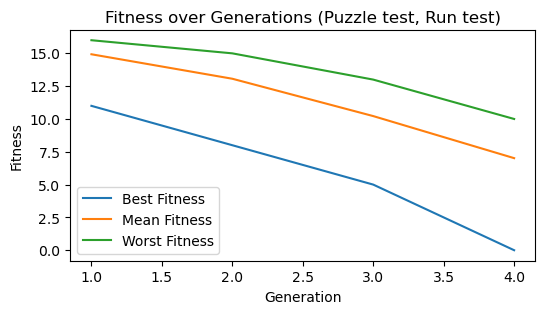

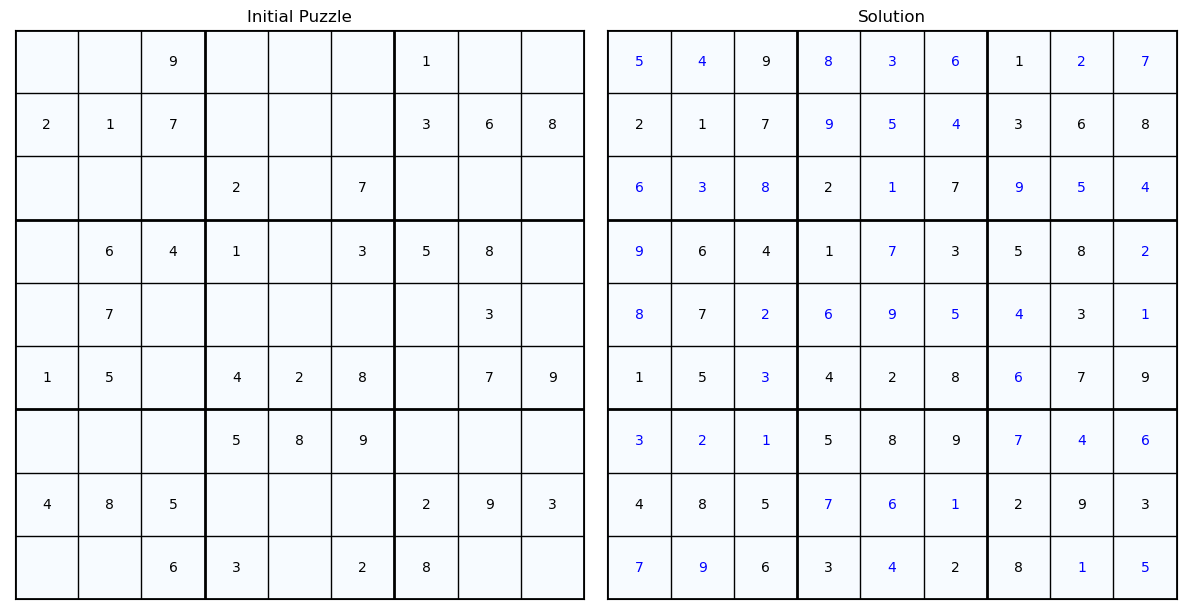

In [8]:
# Example usage
sudoku_puzzle = [
    [0, 0, 9, 0, 0, 0, 1, 0, 0],
    [2, 1, 7, 0, 0, 0, 3, 6, 8],
    [0, 0, 0, 2, 0, 7, 0, 0, 0],
    [0, 6, 4, 1, 0, 3, 5, 8, 0],
    [0, 7, 0, 0, 0, 0, 0, 3, 0],
    [1, 5, 0, 4, 2, 8, 0, 7, 9],
    [0, 0, 0, 5, 8, 9, 0, 0, 0],
    [4, 8, 5, 0, 0, 0, 2, 9, 3],
    [0, 0, 6, 3, 0, 2, 8, 0, 0]
]

lsga = LSGA(sudoku_puzzle,pop_size=200, elite_size=50, max_generations=10000, pc1=0.9, pc2=0.8, pm1=0.3, pm2=0.05, tournament_size=20, experiment_id="test", puzzle_id="test", run_id="test", output_folder="./output/test/")
best_solution, best_fitness, total_generations_to_find_solution = lsga.run()

# Run Experiment Section

Experiment Run At: 2024-07-22_16-34-23
##########################################################################################################################################################################################################################################################
Puzzle ID:  Easy level (No.1)
Initializing population...
Population initialized.
Starting LSGA...
Generation 1: Best fitness = 11
Generation 2: Best fitness = 8
Generation 3: Best fitness = 7
Generation 4: Best fitness = 5
Generation 5: Best fitness = 2
Generation 6: Best fitness = 0
Best solution found with fitness = 0


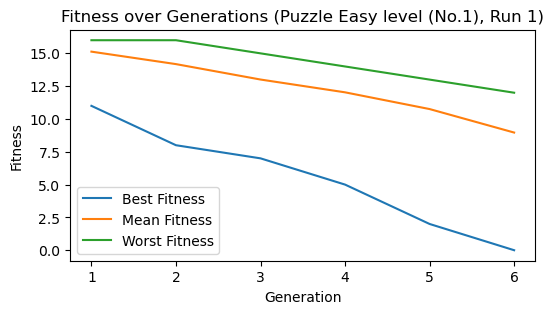

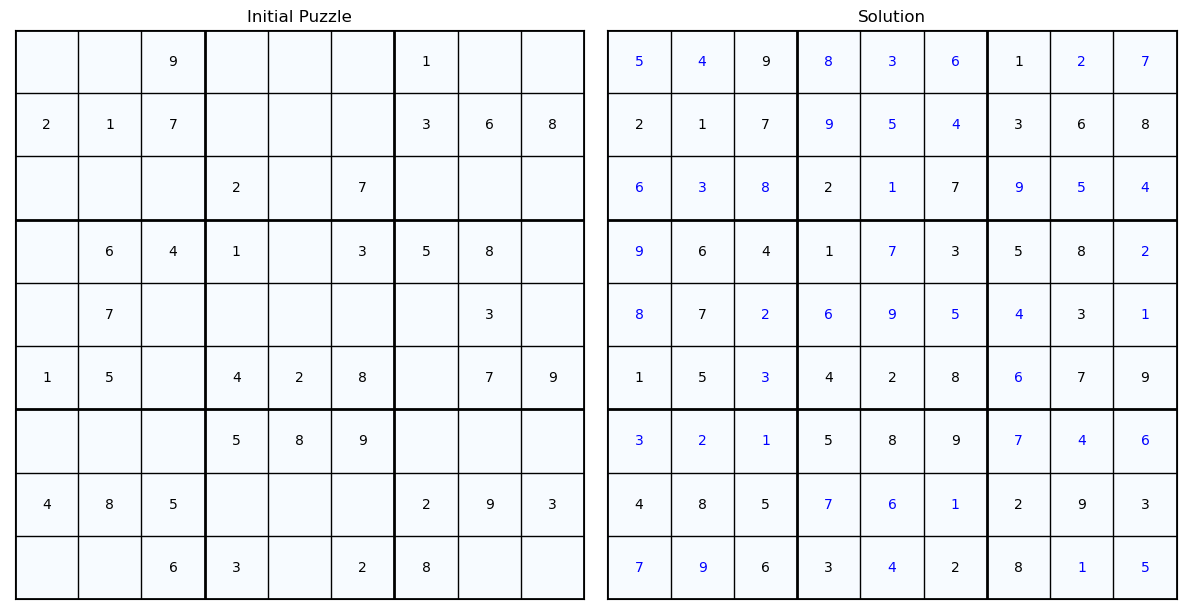

##########################################################################################################################################################################################################################################################
Puzzle ID:  Easy level (No.11)
Initializing population...
Population initialized.
Starting LSGA...
Generation 1: Best fitness = 13
Generation 2: Best fitness = 12
Generation 3: Best fitness = 10
Generation 4: Best fitness = 10
Generation 5: Best fitness = 7
Generation 6: Best fitness = 5
Generation 7: Best fitness = 6
Generation 8: Best fitness = 2
Generation 9: Best fitness = 4


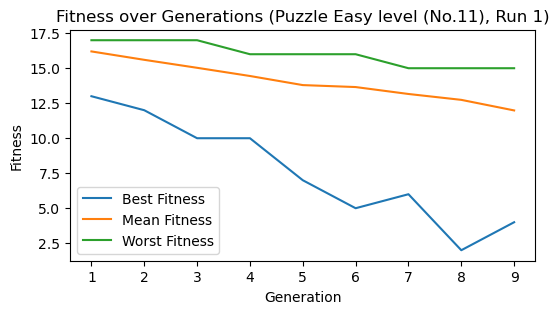

Generation 10: Best fitness = 3
Generation 11: Best fitness = 4
Generation 12: Best fitness = 0
Best solution found with fitness = 0


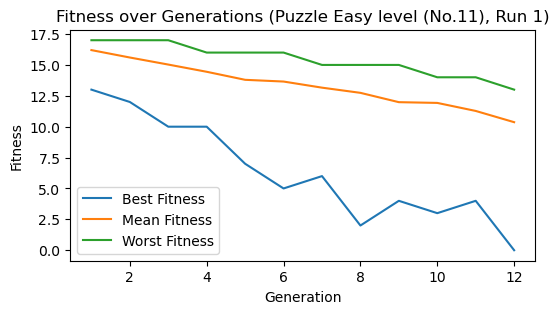

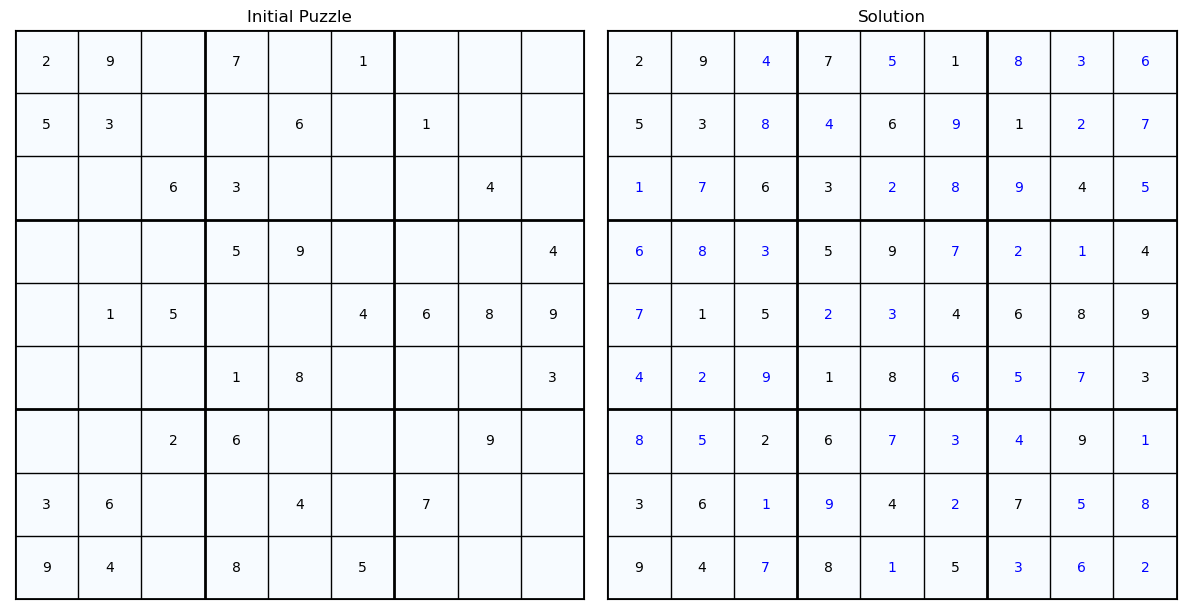

##########################################################################################################################################################################################################################################################
Puzzle ID:  Medium level (No.27)
Initializing population...
Population initialized.
Starting LSGA...
Generation 1: Best fitness = 13
Generation 2: Best fitness = 13
Generation 3: Best fitness = 12
Generation 4: Best fitness = 11
Generation 5: Best fitness = 10
Generation 6: Best fitness = 9
Generation 7: Best fitness = 9
Generation 8: Best fitness = 8
Generation 9: Best fitness = 9


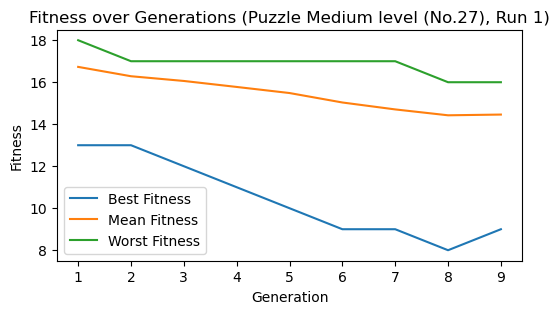

Generation 10: Best fitness = 7
Generation 11: Best fitness = 6
Generation 12: Best fitness = 6
Generation 13: Best fitness = 6
Generation 14: Best fitness = 6
Generation 15: Best fitness = 6
Generation 16: Best fitness = 0
Best solution found with fitness = 0


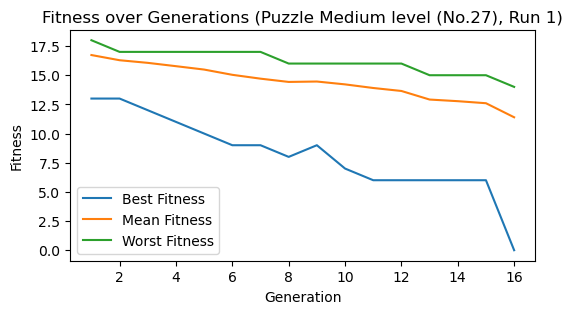

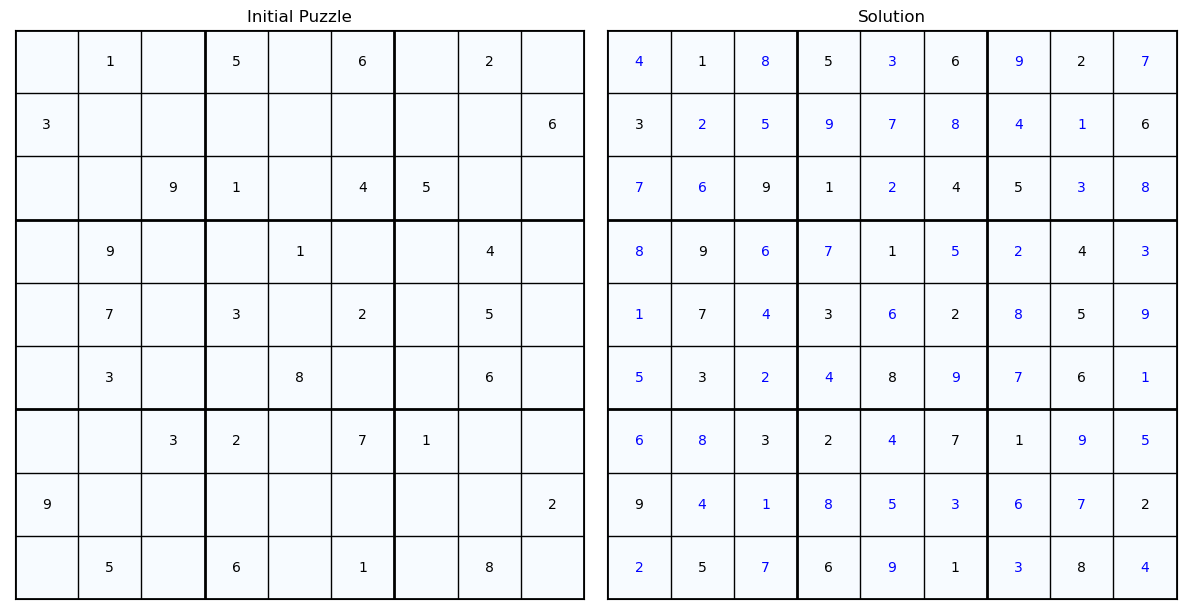

##########################################################################################################################################################################################################################################################
Puzzle ID:  Medium level (No.29)
Initializing population...
Population initialized.
Starting LSGA...
Generation 1: Best fitness = 13
Generation 2: Best fitness = 11
Generation 3: Best fitness = 11
Generation 4: Best fitness = 11
Generation 5: Best fitness = 8
Generation 6: Best fitness = 11
Generation 7: Best fitness = 11
Generation 8: Best fitness = 8
Generation 9: Best fitness = 9


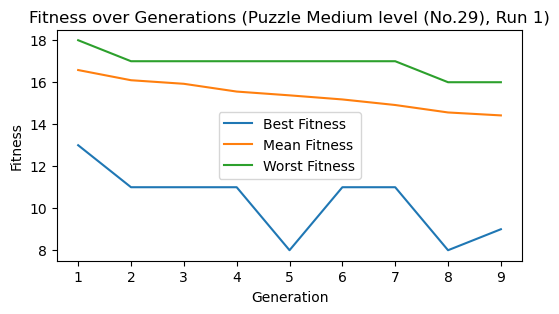

Generation 10: Best fitness = 7
Generation 11: Best fitness = 9
Generation 12: Best fitness = 9
Generation 13: Best fitness = 6
Generation 14: Best fitness = 8
Generation 15: Best fitness = 7
Generation 16: Best fitness = 7
Generation 17: Best fitness = 4
Generation 18: Best fitness = 4
Generation 19: Best fitness = 4


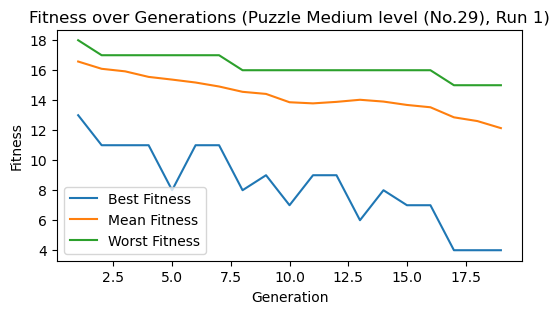

Generation 20: Best fitness = 4
Generation 21: Best fitness = 4
Generation 22: Best fitness = 2
Generation 23: Best fitness = 0
Best solution found with fitness = 0


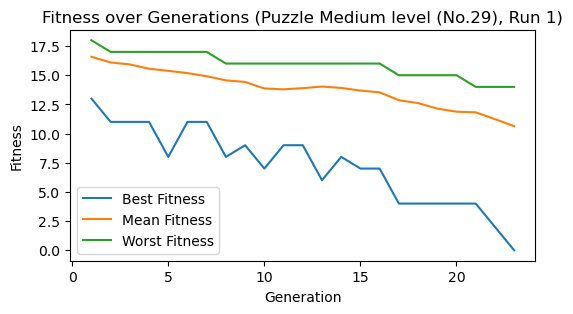

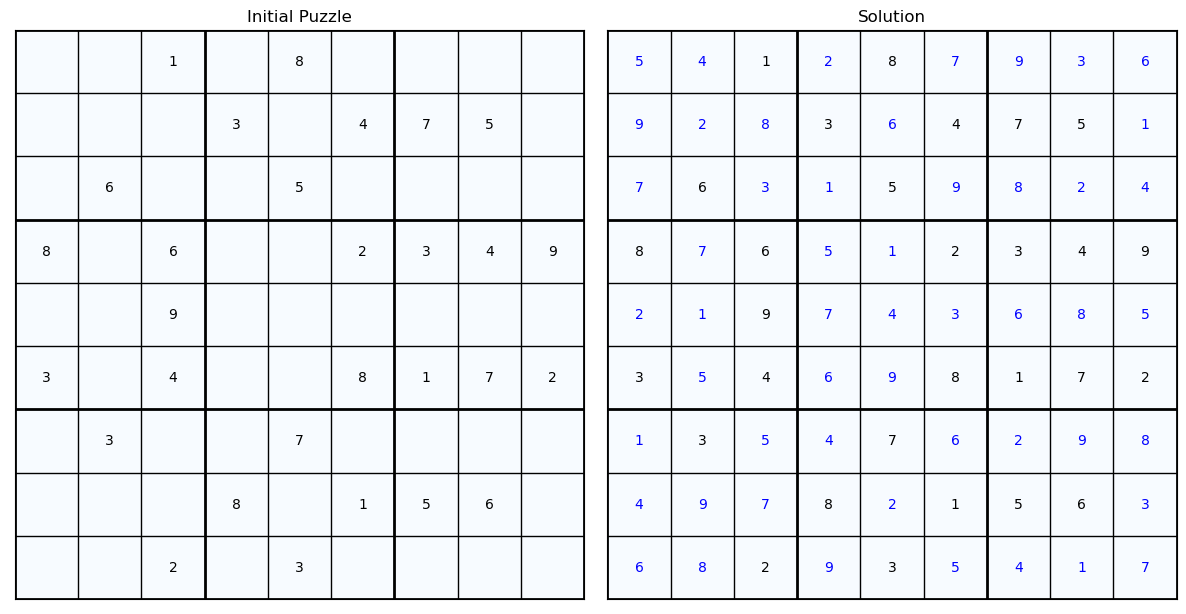

##########################################################################################################################################################################################################################################################
Puzzle ID:  Hard level (No.77)
Initializing population...
Population initialized.
Starting LSGA...
Generation 1: Best fitness = 13
Generation 2: Best fitness = 11
Generation 3: Best fitness = 10
Generation 4: Best fitness = 10
Generation 5: Best fitness = 10
Generation 6: Best fitness = 10
Generation 7: Best fitness = 12
Generation 8: Best fitness = 9
Generation 9: Best fitness = 2


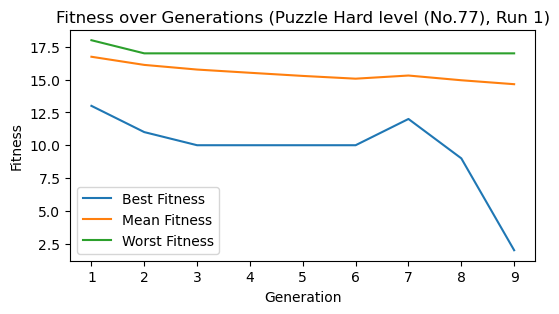

Generation 10: Best fitness = 5
Generation 11: Best fitness = 9
Generation 12: Best fitness = 9
Generation 13: Best fitness = 5
Generation 14: Best fitness = 6
Generation 15: Best fitness = 6
Generation 16: Best fitness = 8
Generation 17: Best fitness = 9
Generation 18: Best fitness = 9
Generation 19: Best fitness = 5


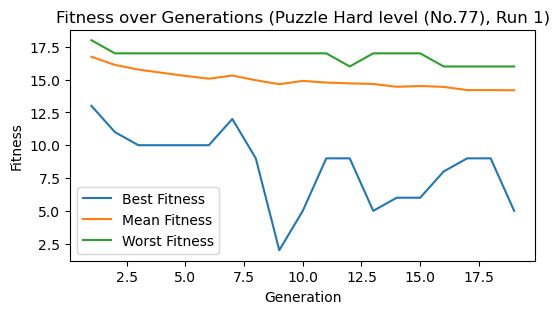

Generation 20: Best fitness = 6
Generation 21: Best fitness = 7
Generation 22: Best fitness = 7
Generation 23: Best fitness = 9
Generation 24: Best fitness = 5
Generation 25: Best fitness = 9
Generation 26: Best fitness = 8
Generation 27: Best fitness = 9
Generation 28: Best fitness = 9
Generation 29: Best fitness = 9


Generation 30: Best fitness = 9
Generation 31: Best fitness = 7
Generation 32: Best fitness = 8
Generation 33: Best fitness = 5
Generation 34: Best fitness = 7
Generation 35: Best fitness = 7
Generation 36: Best fitness = 4
Generation 37: Best fitness = 7
Generation 38: Best fitness = 7
Generation 39: Best fitness = 5


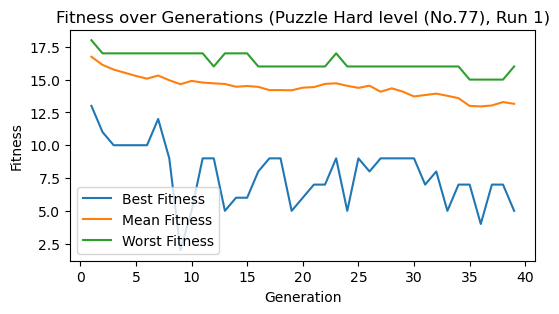

Generation 40: Best fitness = 7
Generation 41: Best fitness = 6
Generation 42: Best fitness = 5
Generation 43: Best fitness = 6
Generation 44: Best fitness = 7
Generation 45: Best fitness = 6
Generation 46: Best fitness = 7
Generation 47: Best fitness = 4
Generation 48: Best fitness = 4
Generation 49: Best fitness = 3


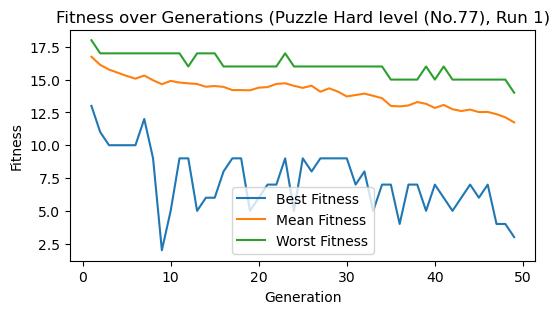

Generation 50: Best fitness = 5
Generation 51: Best fitness = 2
Generation 52: Best fitness = 2
Generation 53: Best fitness = 4
Generation 54: Best fitness = 4
Generation 55: Best fitness = 4
Generation 56: Best fitness = 4
Generation 57: Best fitness = 2
Generation 58: Best fitness = 2
Generation 59: Best fitness = 4


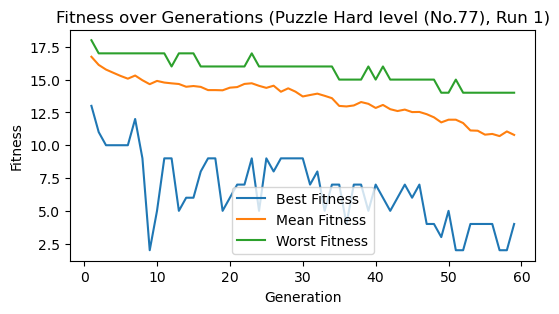

Generation 60: Best fitness = 2
Generation 61: Best fitness = 2
Generation 62: Best fitness = 0
Best solution found with fitness = 0


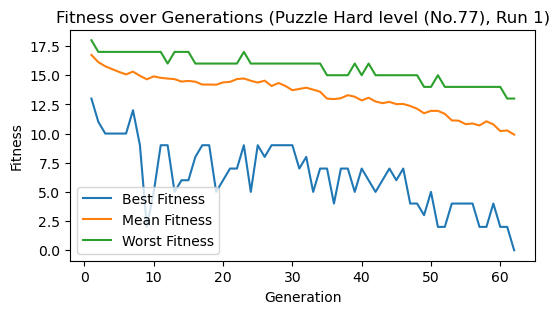

##########################################################################################################################################################################################################################################################
Puzzle ID:  Hard level (No.106)
Initializing population...
Population initialized.
Starting LSGA...
Generation 1: Best fitness = 14
Generation 2: Best fitness = 12
Generation 3: Best fitness = 12
Generation 4: Best fitness = 13
Generation 5: Best fitness = 12
Generation 6: Best fitness = 10
Generation 7: Best fitness = 10
Generation 8: Best fitness = 12
Generation 9: Best fitness = 12


Generation 10: Best fitness = 10
Generation 11: Best fitness = 12
Generation 12: Best fitness = 10
Generation 13: Best fitness = 9
Generation 14: Best fitness = 10
Generation 15: Best fitness = 11
Generation 16: Best fitness = 12
Generation 17: Best fitness = 12
Generation 18: Best fitness = 7
Generation 19: Best fitness = 10


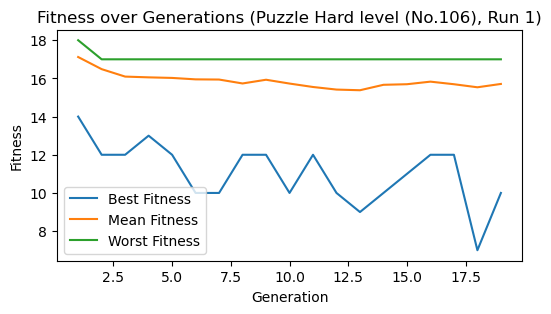

Generation 20: Best fitness = 11
Generation 21: Best fitness = 11
Generation 22: Best fitness = 10
Generation 23: Best fitness = 10
Generation 24: Best fitness = 10
Generation 25: Best fitness = 11
Generation 26: Best fitness = 8
Generation 27: Best fitness = 10
Generation 28: Best fitness = 11
Generation 29: Best fitness = 11


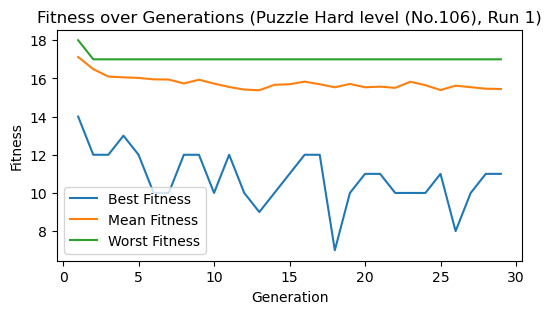

Generation 30: Best fitness = 8
Generation 31: Best fitness = 11
Generation 32: Best fitness = 10
Generation 33: Best fitness = 6
Generation 34: Best fitness = 10
Generation 35: Best fitness = 9
Generation 36: Best fitness = 9
Generation 37: Best fitness = 10
Generation 38: Best fitness = 8
Generation 39: Best fitness = 10


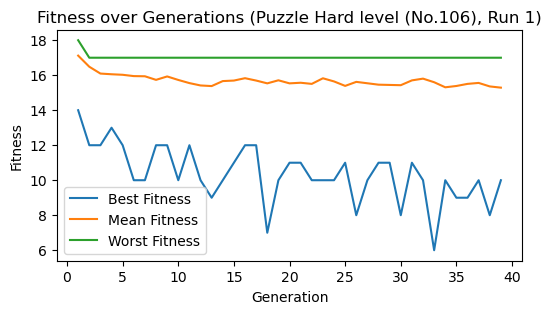

Generation 40: Best fitness = 7
Generation 41: Best fitness = 10
Generation 42: Best fitness = 9
Generation 43: Best fitness = 10
Generation 44: Best fitness = 9
Generation 45: Best fitness = 6
Generation 46: Best fitness = 7
Generation 47: Best fitness = 10
Generation 48: Best fitness = 8
Generation 49: Best fitness = 9


Generation 50: Best fitness = 9
Generation 51: Best fitness = 9
Generation 52: Best fitness = 10
Generation 53: Best fitness = 9
Generation 54: Best fitness = 7
Generation 55: Best fitness = 7
Generation 56: Best fitness = 10
Generation 57: Best fitness = 9
Generation 58: Best fitness = 7
Generation 59: Best fitness = 9


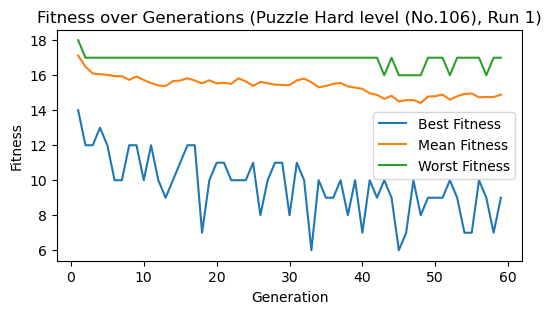

Generation 60: Best fitness = 10
Generation 61: Best fitness = 10
Generation 62: Best fitness = 10
Generation 63: Best fitness = 9
Generation 64: Best fitness = 11
Generation 65: Best fitness = 9
Generation 66: Best fitness = 7
Generation 67: Best fitness = 10
Generation 68: Best fitness = 11
Generation 69: Best fitness = 10


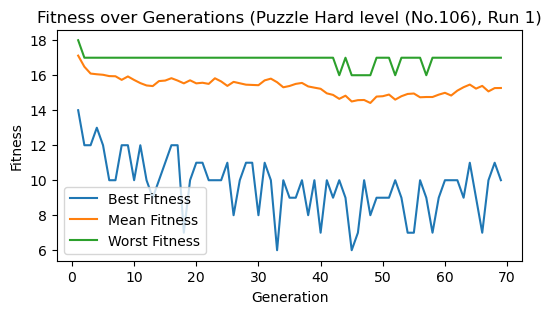

Generation 70: Best fitness = 10
Generation 71: Best fitness = 11
Generation 72: Best fitness = 9
Generation 73: Best fitness = 9
Generation 74: Best fitness = 10
Generation 75: Best fitness = 10
Generation 76: Best fitness = 10
Generation 77: Best fitness = 8
Generation 78: Best fitness = 11
Generation 79: Best fitness = 8


Generation 80: Best fitness = 10
Generation 81: Best fitness = 11
Generation 82: Best fitness = 10
Generation 83: Best fitness = 10
Generation 84: Best fitness = 9
Generation 85: Best fitness = 12
Generation 86: Best fitness = 10
Generation 87: Best fitness = 10
Generation 88: Best fitness = 7
Generation 89: Best fitness = 10


Generation 90: Best fitness = 12
Generation 91: Best fitness = 11
Generation 92: Best fitness = 9
Generation 93: Best fitness = 11
Generation 94: Best fitness = 10
Generation 95: Best fitness = 8
Generation 96: Best fitness = 9
Generation 97: Best fitness = 7
Generation 98: Best fitness = 12
Generation 99: Best fitness = 10


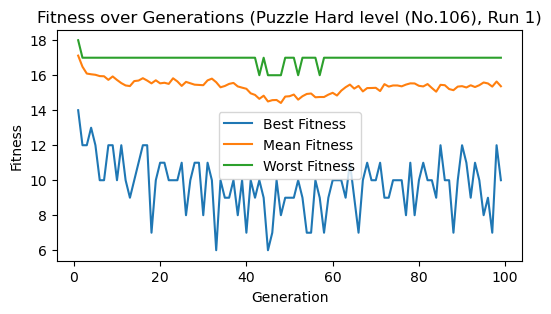

Generation 100: Best fitness = 9
Generation 101: Best fitness = 11
Generation 102: Best fitness = 11
Generation 103: Best fitness = 11
Generation 104: Best fitness = 5
Generation 105: Best fitness = 9
Generation 106: Best fitness = 9
Generation 107: Best fitness = 11
Generation 108: Best fitness = 11
Generation 109: Best fitness = 6


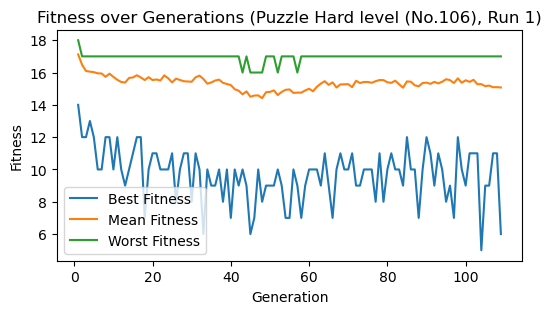

Generation 110: Best fitness = 8
Generation 111: Best fitness = 6
Generation 112: Best fitness = 7
Generation 113: Best fitness = 4
Generation 114: Best fitness = 8
Generation 115: Best fitness = 9
Generation 116: Best fitness = 11
Generation 117: Best fitness = 7
Generation 118: Best fitness = 8
Generation 119: Best fitness = 12


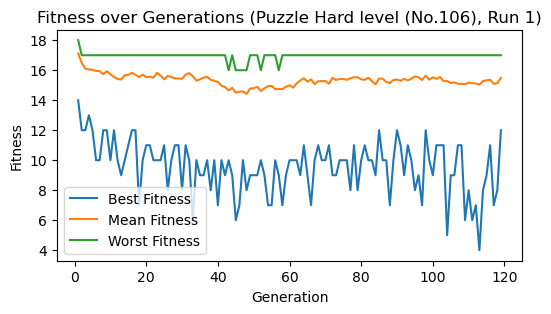

Generation 120: Best fitness = 9
Generation 121: Best fitness = 12
Generation 122: Best fitness = 9
Generation 123: Best fitness = 10
Generation 124: Best fitness = 10
Generation 125: Best fitness = 8
Generation 126: Best fitness = 10
Generation 127: Best fitness = 10
Generation 128: Best fitness = 11
Generation 129: Best fitness = 9


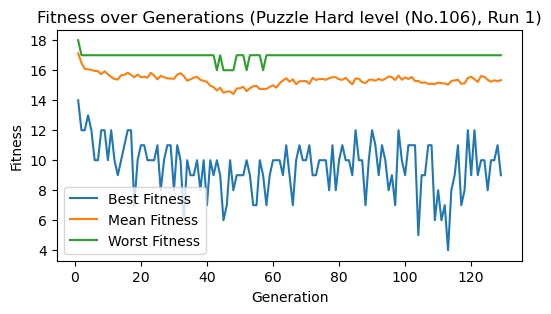

Generation 130: Best fitness = 12
Generation 131: Best fitness = 11
Generation 132: Best fitness = 7
Generation 133: Best fitness = 7
Generation 134: Best fitness = 10
Generation 135: Best fitness = 10
Generation 136: Best fitness = 9
Generation 137: Best fitness = 8
Generation 138: Best fitness = 10
Generation 139: Best fitness = 10


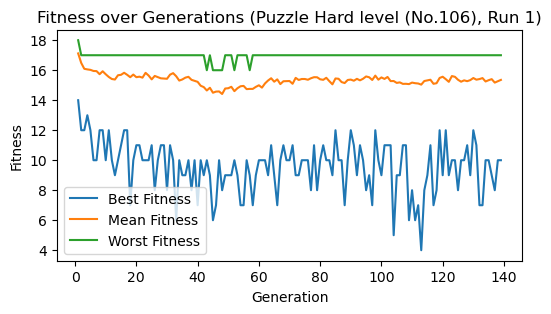

Generation 140: Best fitness = 8
Generation 141: Best fitness = 8
Generation 142: Best fitness = 9
Generation 143: Best fitness = 11
Generation 144: Best fitness = 9
Generation 145: Best fitness = 10
Generation 146: Best fitness = 9
Generation 147: Best fitness = 9
Generation 148: Best fitness = 10
Generation 149: Best fitness = 8


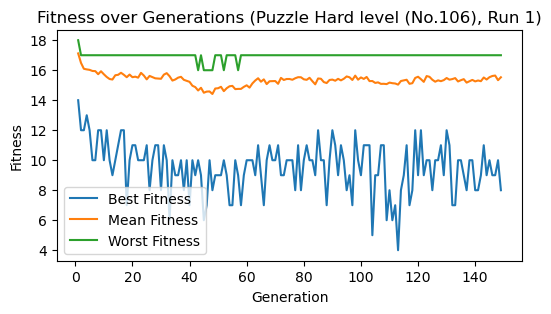

Generation 150: Best fitness = 4
Generation 151: Best fitness = 6
Generation 152: Best fitness = 7
Generation 153: Best fitness = 10
Generation 154: Best fitness = 10
Generation 155: Best fitness = 7
Generation 156: Best fitness = 9
Generation 157: Best fitness = 10
Generation 158: Best fitness = 9
Generation 159: Best fitness = 11


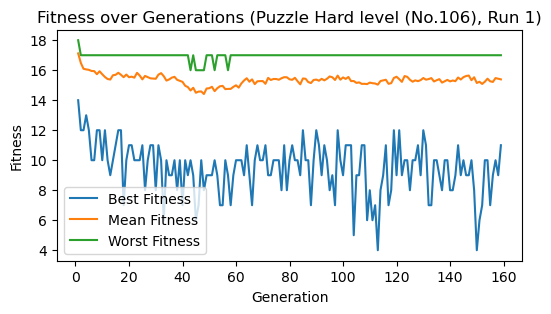

Generation 160: Best fitness = 10
Generation 161: Best fitness = 11
Generation 162: Best fitness = 10
Generation 163: Best fitness = 10
Generation 164: Best fitness = 10
Generation 165: Best fitness = 11
Generation 166: Best fitness = 10
Generation 167: Best fitness = 9
Generation 168: Best fitness = 11
Generation 169: Best fitness = 8


Generation 170: Best fitness = 7
Generation 171: Best fitness = 8
Generation 172: Best fitness = 9
Generation 173: Best fitness = 10
Generation 174: Best fitness = 6
Generation 175: Best fitness = 9
Generation 176: Best fitness = 10
Generation 177: Best fitness = 11
Generation 178: Best fitness = 12
Generation 179: Best fitness = 9


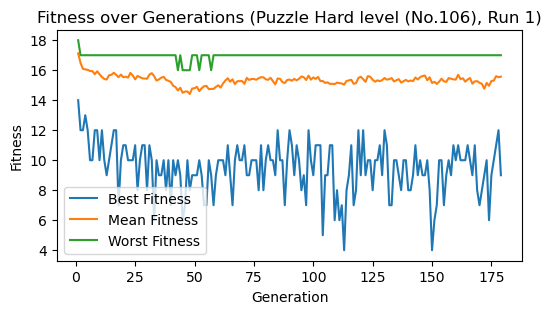

Generation 180: Best fitness = 11
Generation 181: Best fitness = 8
Generation 182: Best fitness = 11
Generation 183: Best fitness = 10
Generation 184: Best fitness = 10
Generation 185: Best fitness = 11
Generation 186: Best fitness = 10
Generation 187: Best fitness = 10
Generation 188: Best fitness = 11
Generation 189: Best fitness = 9


Generation 190: Best fitness = 9
Generation 191: Best fitness = 10
Generation 192: Best fitness = 8
Generation 193: Best fitness = 10
Generation 194: Best fitness = 10
Generation 195: Best fitness = 10
Generation 196: Best fitness = 12
Generation 197: Best fitness = 8
Generation 198: Best fitness = 11
Generation 199: Best fitness = 9


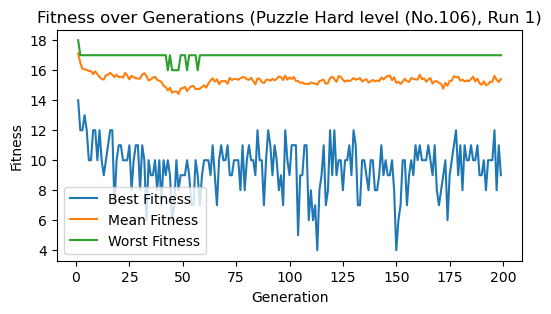

Generation 200: Best fitness = 9
Generation 201: Best fitness = 10
Generation 202: Best fitness = 9
Generation 203: Best fitness = 7
Generation 204: Best fitness = 9
Generation 205: Best fitness = 8
Generation 206: Best fitness = 6
Generation 207: Best fitness = 6
Generation 208: Best fitness = 7
Generation 209: Best fitness = 6


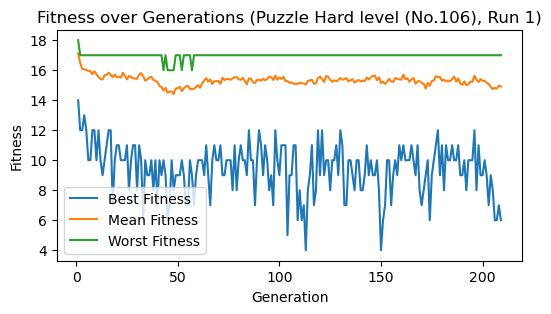

Generation 210: Best fitness = 10
Generation 211: Best fitness = 10
Generation 212: Best fitness = 11
Generation 213: Best fitness = 9
Generation 214: Best fitness = 10
Generation 215: Best fitness = 9
Generation 216: Best fitness = 11
Generation 217: Best fitness = 11
Generation 218: Best fitness = 11
Generation 219: Best fitness = 8


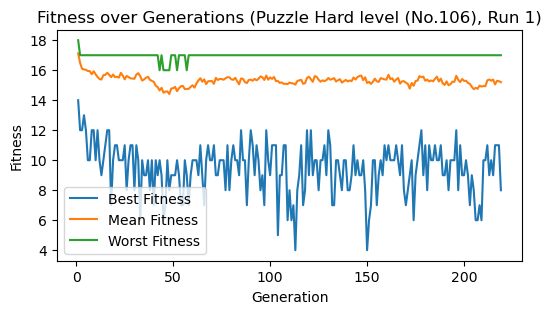

Generation 220: Best fitness = 8
Generation 221: Best fitness = 11
Generation 222: Best fitness = 11
Generation 223: Best fitness = 9
Generation 224: Best fitness = 9
Generation 225: Best fitness = 10
Generation 226: Best fitness = 11
Generation 227: Best fitness = 10
Generation 228: Best fitness = 9
Generation 229: Best fitness = 8


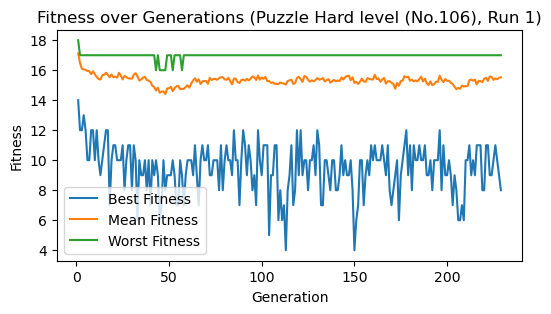

Generation 230: Best fitness = 10
Generation 231: Best fitness = 11
Generation 232: Best fitness = 12
Generation 233: Best fitness = 11
Generation 234: Best fitness = 10
Generation 235: Best fitness = 9
Generation 236: Best fitness = 9
Generation 237: Best fitness = 10
Generation 238: Best fitness = 8
Generation 239: Best fitness = 10


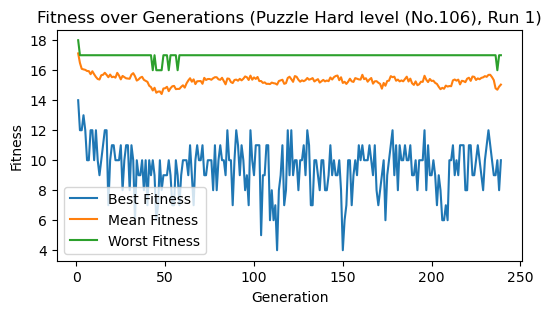

Generation 240: Best fitness = 10
Generation 241: Best fitness = 8
Generation 242: Best fitness = 9
Generation 243: Best fitness = 9
Generation 244: Best fitness = 6
Generation 245: Best fitness = 9
Generation 246: Best fitness = 11
Generation 247: Best fitness = 11
Generation 248: Best fitness = 11
Generation 249: Best fitness = 9


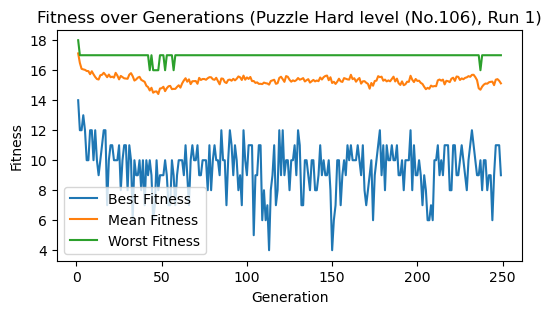

Generation 250: Best fitness = 9
Generation 251: Best fitness = 11
Generation 252: Best fitness = 6
Generation 253: Best fitness = 10
Generation 254: Best fitness = 9
Generation 255: Best fitness = 9
Generation 256: Best fitness = 11
Generation 257: Best fitness = 11
Generation 258: Best fitness = 11
Generation 259: Best fitness = 11


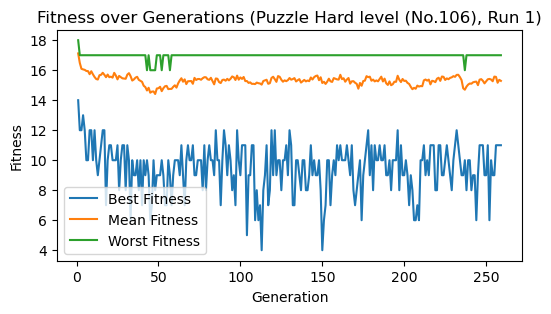

Generation 260: Best fitness = 11
Generation 261: Best fitness = 10
Generation 262: Best fitness = 8
Generation 263: Best fitness = 10
Generation 264: Best fitness = 9
Generation 265: Best fitness = 10
Generation 266: Best fitness = 11
Generation 267: Best fitness = 11
Generation 268: Best fitness = 10
Generation 269: Best fitness = 9


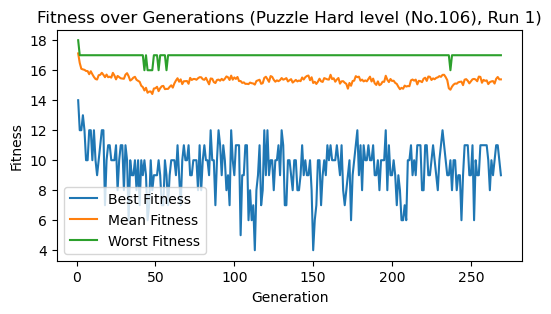

Generation 270: Best fitness = 8
Generation 271: Best fitness = 8
Generation 272: Best fitness = 10
Generation 273: Best fitness = 11
Generation 274: Best fitness = 10
Generation 275: Best fitness = 10
Generation 276: Best fitness = 8
Generation 277: Best fitness = 8
Generation 278: Best fitness = 10
Generation 279: Best fitness = 8


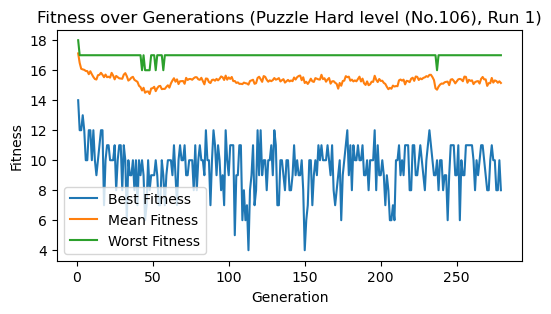

Generation 280: Best fitness = 7
Generation 281: Best fitness = 8
Generation 282: Best fitness = 9
Generation 283: Best fitness = 9
Generation 284: Best fitness = 9
Generation 285: Best fitness = 10
Generation 286: Best fitness = 10
Generation 287: Best fitness = 7
Generation 288: Best fitness = 8
Generation 289: Best fitness = 8


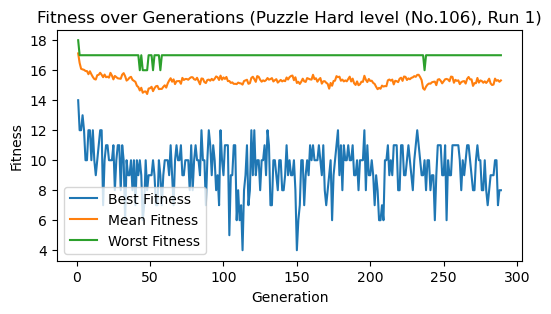

Generation 290: Best fitness = 7
Generation 291: Best fitness = 9
Generation 292: Best fitness = 11
Generation 293: Best fitness = 10
Generation 294: Best fitness = 9
Generation 295: Best fitness = 10
Generation 296: Best fitness = 10
Generation 297: Best fitness = 9
Generation 298: Best fitness = 11
Generation 299: Best fitness = 11


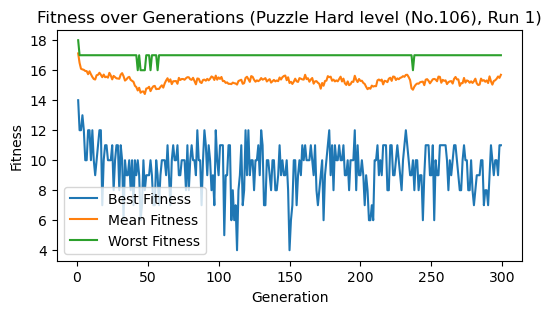

Generation 300: Best fitness = 10
Generation 301: Best fitness = 10
Generation 302: Best fitness = 10
Generation 303: Best fitness = 12
Generation 304: Best fitness = 12
Generation 305: Best fitness = 9
Generation 306: Best fitness = 10
Generation 307: Best fitness = 10
Generation 308: Best fitness = 12
Generation 309: Best fitness = 8


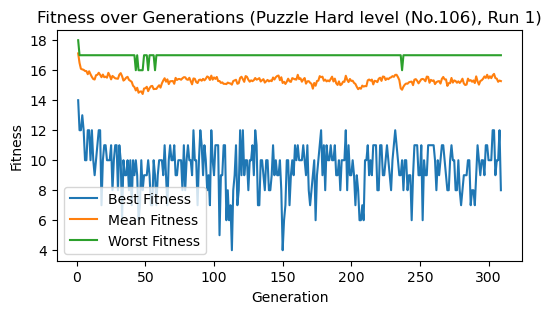

Generation 310: Best fitness = 9
Generation 311: Best fitness = 7
Generation 312: Best fitness = 11
Generation 313: Best fitness = 9
Generation 314: Best fitness = 9
Generation 315: Best fitness = 10
Generation 316: Best fitness = 10
Generation 317: Best fitness = 11
Generation 318: Best fitness = 8
Generation 319: Best fitness = 9


Generation 320: Best fitness = 10
Generation 321: Best fitness = 10
Generation 322: Best fitness = 10
Generation 323: Best fitness = 9
Generation 324: Best fitness = 10
Generation 325: Best fitness = 9
Generation 326: Best fitness = 10
Generation 327: Best fitness = 10
Generation 328: Best fitness = 10
Generation 329: Best fitness = 11


Generation 330: Best fitness = 10
Generation 331: Best fitness = 10
Generation 332: Best fitness = 10
Generation 333: Best fitness = 10
Generation 334: Best fitness = 8
Generation 335: Best fitness = 7
Generation 336: Best fitness = 9
Generation 337: Best fitness = 9
Generation 338: Best fitness = 10
Generation 339: Best fitness = 10


Generation 340: Best fitness = 9
Generation 341: Best fitness = 9
Generation 342: Best fitness = 8
Generation 343: Best fitness = 11
Generation 344: Best fitness = 10
Generation 345: Best fitness = 8
Generation 346: Best fitness = 10
Generation 347: Best fitness = 9
Generation 348: Best fitness = 7
Generation 349: Best fitness = 9


Generation 350: Best fitness = 9
Generation 351: Best fitness = 10
Generation 352: Best fitness = 10
Generation 353: Best fitness = 10
Generation 354: Best fitness = 4
Generation 355: Best fitness = 9
Generation 356: Best fitness = 9
Generation 357: Best fitness = 10
Generation 358: Best fitness = 11
Generation 359: Best fitness = 10


Generation 360: Best fitness = 9
Generation 361: Best fitness = 6
Generation 362: Best fitness = 9
Generation 363: Best fitness = 10
Generation 364: Best fitness = 9
Generation 365: Best fitness = 11
Generation 366: Best fitness = 10
Generation 367: Best fitness = 10
Generation 368: Best fitness = 10
Generation 369: Best fitness = 9


Generation 370: Best fitness = 8
Generation 371: Best fitness = 8
Generation 372: Best fitness = 4
Generation 373: Best fitness = 4
Generation 374: Best fitness = 8
Generation 375: Best fitness = 6
Generation 376: Best fitness = 8
Generation 377: Best fitness = 7
Generation 378: Best fitness = 7
Generation 379: Best fitness = 8


Generation 380: Best fitness = 7
Generation 381: Best fitness = 7
Generation 382: Best fitness = 7
Generation 383: Best fitness = 9
Generation 384: Best fitness = 10
Generation 385: Best fitness = 9
Generation 386: Best fitness = 6
Generation 387: Best fitness = 5
Generation 388: Best fitness = 10
Generation 389: Best fitness = 7


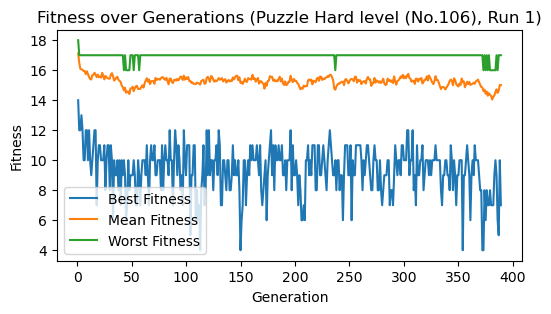

Generation 390: Best fitness = 6
Generation 391: Best fitness = 5
Generation 392: Best fitness = 7
Generation 393: Best fitness = 6
Generation 394: Best fitness = 6
Generation 395: Best fitness = 6
Generation 396: Best fitness = 6
Generation 397: Best fitness = 8
Generation 398: Best fitness = 9
Generation 399: Best fitness = 8


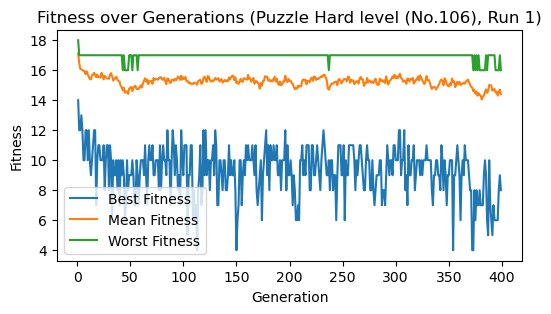

Generation 400: Best fitness = 5
Generation 401: Best fitness = 9
Generation 402: Best fitness = 6
Generation 403: Best fitness = 5
Generation 404: Best fitness = 6
Generation 405: Best fitness = 9
Generation 406: Best fitness = 7
Generation 407: Best fitness = 5
Generation 408: Best fitness = 5
Generation 409: Best fitness = 5


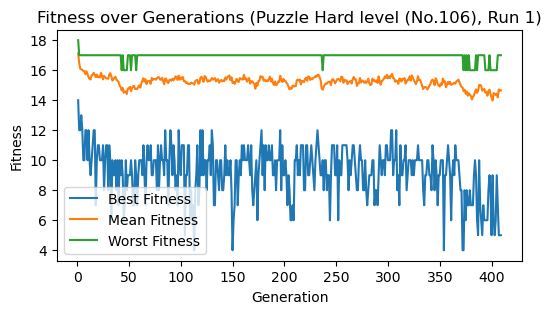

Generation 410: Best fitness = 8
Generation 411: Best fitness = 6
Generation 412: Best fitness = 10
Generation 413: Best fitness = 4
Generation 414: Best fitness = 6
Generation 415: Best fitness = 7
Generation 416: Best fitness = 9
Generation 417: Best fitness = 7
Generation 418: Best fitness = 5
Generation 419: Best fitness = 6


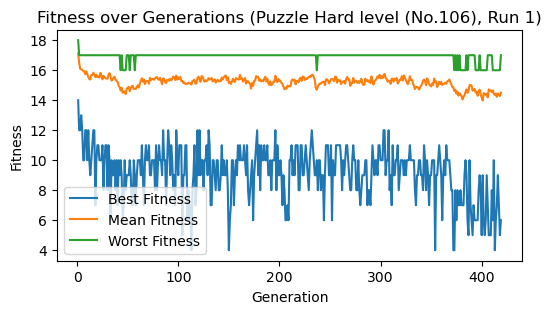

Generation 420: Best fitness = 7
Generation 421: Best fitness = 8
Generation 422: Best fitness = 7
Generation 423: Best fitness = 6
Generation 424: Best fitness = 7
Generation 425: Best fitness = 8
Generation 426: Best fitness = 9
Generation 427: Best fitness = 7
Generation 428: Best fitness = 8
Generation 429: Best fitness = 8


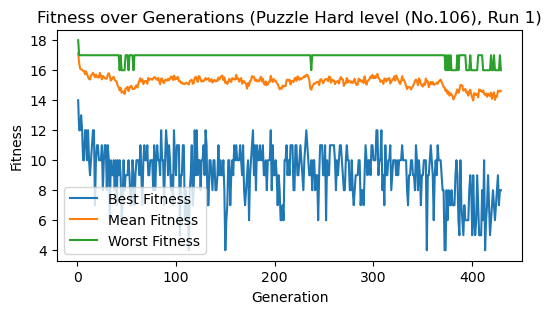

Generation 430: Best fitness = 9
Generation 431: Best fitness = 9
Generation 432: Best fitness = 9
Generation 433: Best fitness = 10
Generation 434: Best fitness = 9
Generation 435: Best fitness = 9
Generation 436: Best fitness = 8
Generation 437: Best fitness = 6
Generation 438: Best fitness = 5
Generation 439: Best fitness = 7


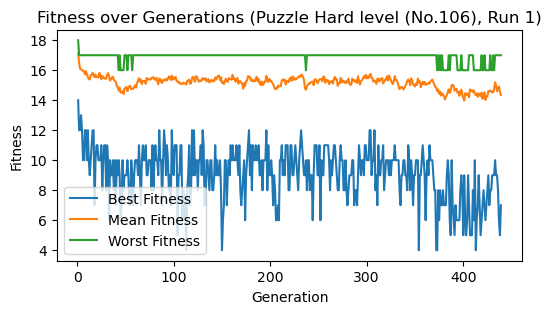

Generation 440: Best fitness = 8
Generation 441: Best fitness = 8
Generation 442: Best fitness = 6
Generation 443: Best fitness = 6
Generation 444: Best fitness = 7
Generation 445: Best fitness = 10
Generation 446: Best fitness = 9
Generation 447: Best fitness = 9
Generation 448: Best fitness = 11
Generation 449: Best fitness = 10


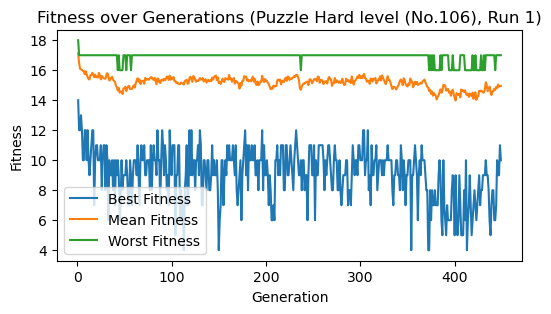

Generation 450: Best fitness = 5
Generation 451: Best fitness = 10
Generation 452: Best fitness = 8
Generation 453: Best fitness = 10
Generation 454: Best fitness = 8
Generation 455: Best fitness = 10
Generation 456: Best fitness = 8
Generation 457: Best fitness = 10
Generation 458: Best fitness = 9
Generation 459: Best fitness = 9


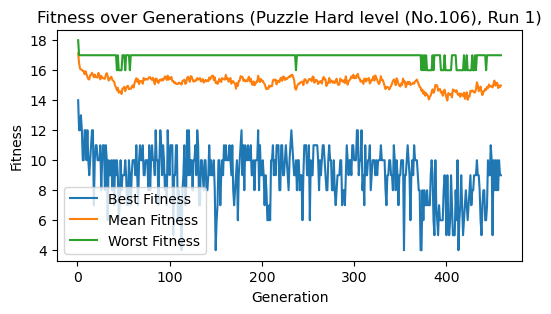

Generation 460: Best fitness = 7
Generation 461: Best fitness = 10
Generation 462: Best fitness = 7
Generation 463: Best fitness = 10
Generation 464: Best fitness = 8
Generation 465: Best fitness = 10
Generation 466: Best fitness = 9
Generation 467: Best fitness = 8
Generation 468: Best fitness = 9
Generation 469: Best fitness = 9


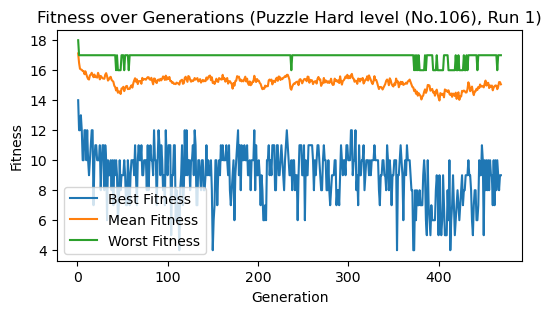

Generation 470: Best fitness = 11
Generation 471: Best fitness = 11
Generation 472: Best fitness = 11
Generation 473: Best fitness = 9
Generation 474: Best fitness = 10
Generation 475: Best fitness = 10
Generation 476: Best fitness = 9
Generation 477: Best fitness = 9
Generation 478: Best fitness = 10
Generation 479: Best fitness = 9


Generation 480: Best fitness = 10
Generation 481: Best fitness = 10
Generation 482: Best fitness = 10
Generation 483: Best fitness = 8
Generation 484: Best fitness = 7
Generation 485: Best fitness = 8
Generation 486: Best fitness = 10
Generation 487: Best fitness = 9
Generation 488: Best fitness = 11
Generation 489: Best fitness = 8


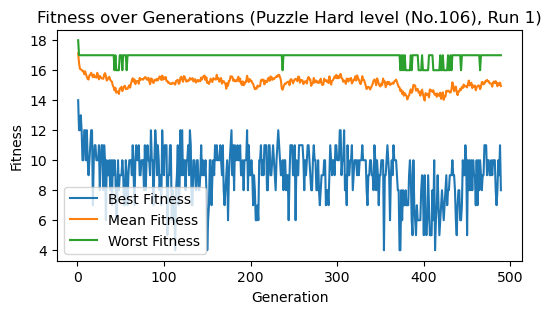

Generation 490: Best fitness = 7
Generation 491: Best fitness = 9
Generation 492: Best fitness = 9
Generation 493: Best fitness = 8
Generation 494: Best fitness = 11
Generation 495: Best fitness = 11
Generation 496: Best fitness = 11
Generation 497: Best fitness = 10
Generation 498: Best fitness = 9
Generation 499: Best fitness = 10


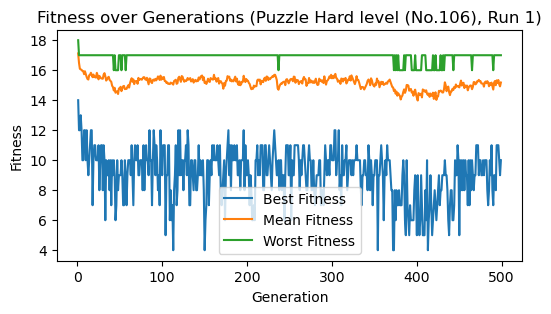

Generation 500: Best fitness = 10
Generation 501: Best fitness = 10
Generation 502: Best fitness = 9
Generation 503: Best fitness = 7
Generation 504: Best fitness = 9
Generation 505: Best fitness = 9
Generation 506: Best fitness = 8
Generation 507: Best fitness = 5
Generation 508: Best fitness = 5
Generation 509: Best fitness = 2


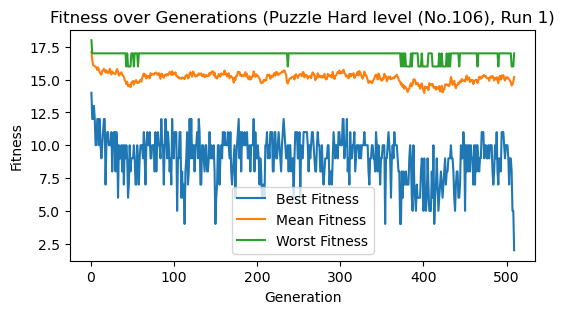

Generation 510: Best fitness = 8
Generation 511: Best fitness = 10
Generation 512: Best fitness = 8
Generation 513: Best fitness = 9
Generation 514: Best fitness = 8
Generation 515: Best fitness = 2
Generation 516: Best fitness = 9
Generation 517: Best fitness = 11
Generation 518: Best fitness = 7
Generation 519: Best fitness = 8


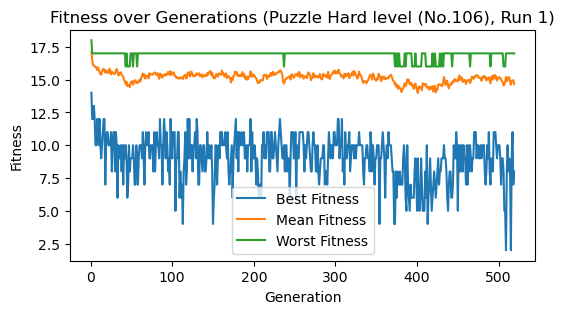

Generation 520: Best fitness = 8
Generation 521: Best fitness = 8
Generation 522: Best fitness = 9
Generation 523: Best fitness = 4
Generation 524: Best fitness = 9
Generation 525: Best fitness = 7
Generation 526: Best fitness = 8
Generation 527: Best fitness = 9
Generation 528: Best fitness = 10
Generation 529: Best fitness = 10


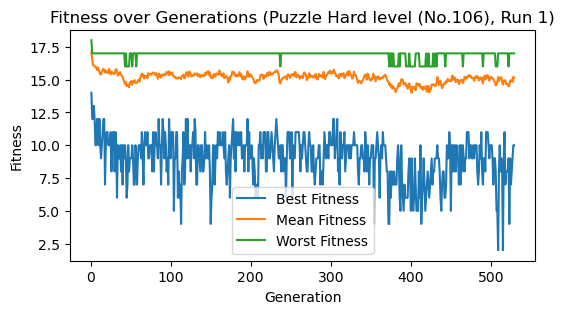

Generation 530: Best fitness = 10
Generation 531: Best fitness = 10
Generation 532: Best fitness = 10
Generation 533: Best fitness = 2
Generation 534: Best fitness = 7
Generation 535: Best fitness = 6
Generation 536: Best fitness = 7
Generation 537: Best fitness = 9
Generation 538: Best fitness = 4
Generation 539: Best fitness = 10


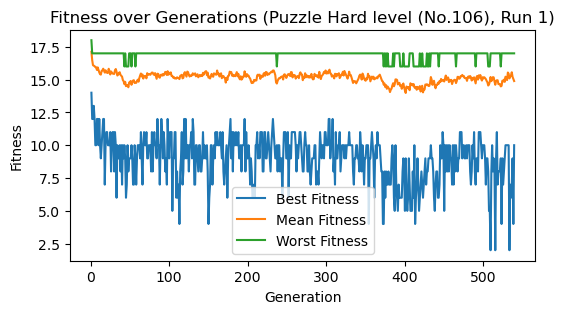

Generation 540: Best fitness = 4
Generation 541: Best fitness = 8
Generation 542: Best fitness = 7
Generation 543: Best fitness = 8
Generation 544: Best fitness = 10
Generation 545: Best fitness = 9
Generation 546: Best fitness = 8
Generation 547: Best fitness = 8
Generation 548: Best fitness = 10
Generation 549: Best fitness = 9


Generation 550: Best fitness = 4
Generation 551: Best fitness = 5
Generation 552: Best fitness = 9
Generation 553: Best fitness = 9
Generation 554: Best fitness = 10
Generation 555: Best fitness = 9
Generation 556: Best fitness = 2
Generation 557: Best fitness = 5
Generation 558: Best fitness = 7
Generation 559: Best fitness = 8


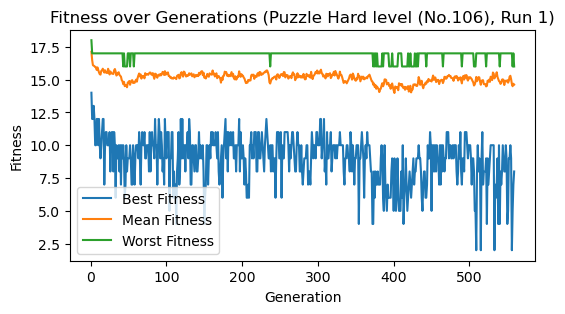

Generation 560: Best fitness = 7
Generation 561: Best fitness = 7
Generation 562: Best fitness = 7
Generation 563: Best fitness = 8
Generation 564: Best fitness = 8
Generation 565: Best fitness = 7
Generation 566: Best fitness = 8
Generation 567: Best fitness = 7
Generation 568: Best fitness = 8
Generation 569: Best fitness = 7


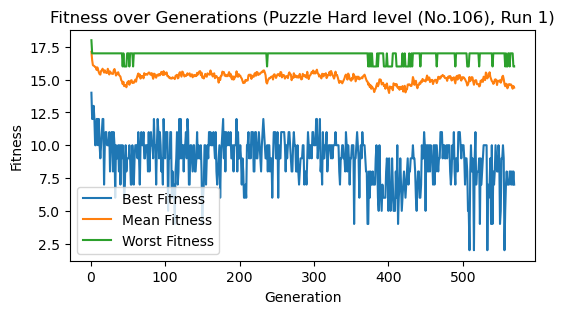

Generation 570: Best fitness = 7
Generation 571: Best fitness = 8
Generation 572: Best fitness = 7
Generation 573: Best fitness = 9
Generation 574: Best fitness = 8
Generation 575: Best fitness = 9
Generation 576: Best fitness = 7
Generation 577: Best fitness = 5
Generation 578: Best fitness = 8
Generation 579: Best fitness = 9


Generation 580: Best fitness = 7
Generation 581: Best fitness = 7
Generation 582: Best fitness = 8
Generation 583: Best fitness = 2
Generation 584: Best fitness = 2
Generation 585: Best fitness = 8
Generation 586: Best fitness = 7
Generation 587: Best fitness = 7
Generation 588: Best fitness = 7
Generation 589: Best fitness = 9


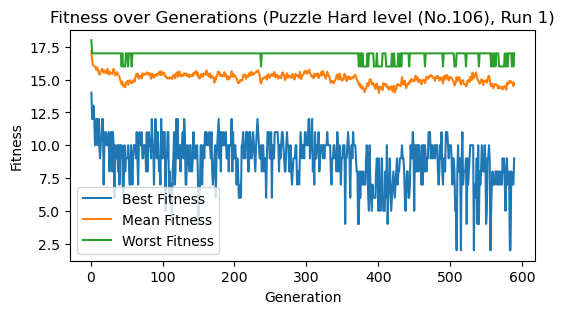

Generation 590: Best fitness = 9
Generation 591: Best fitness = 10
Generation 592: Best fitness = 8
Generation 593: Best fitness = 8
Generation 594: Best fitness = 7
Generation 595: Best fitness = 6
Generation 596: Best fitness = 7
Generation 597: Best fitness = 9
Generation 598: Best fitness = 7
Generation 599: Best fitness = 7


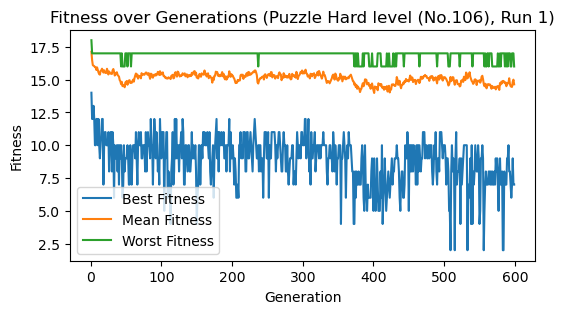

Generation 600: Best fitness = 8
Generation 601: Best fitness = 8
Generation 602: Best fitness = 7
Generation 603: Best fitness = 5
Generation 604: Best fitness = 9
Generation 605: Best fitness = 8
Generation 606: Best fitness = 7
Generation 607: Best fitness = 9
Generation 608: Best fitness = 9
Generation 609: Best fitness = 6


Generation 610: Best fitness = 7
Generation 611: Best fitness = 8
Generation 612: Best fitness = 8
Generation 613: Best fitness = 9
Generation 614: Best fitness = 6
Generation 615: Best fitness = 9
Generation 616: Best fitness = 4
Generation 617: Best fitness = 5
Generation 618: Best fitness = 5
Generation 619: Best fitness = 4


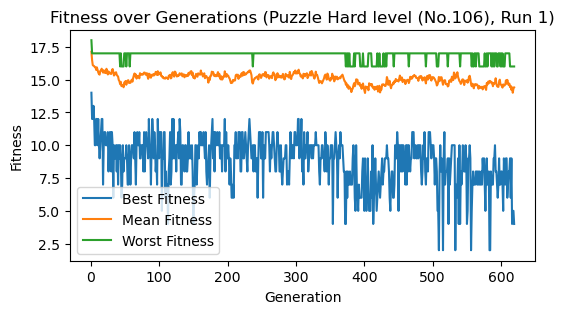

Generation 620: Best fitness = 5
Generation 621: Best fitness = 6
Generation 622: Best fitness = 6
Generation 623: Best fitness = 5
Generation 624: Best fitness = 4
Generation 625: Best fitness = 3
Generation 626: Best fitness = 4
Generation 627: Best fitness = 4
Generation 628: Best fitness = 0
Best solution found with fitness = 0


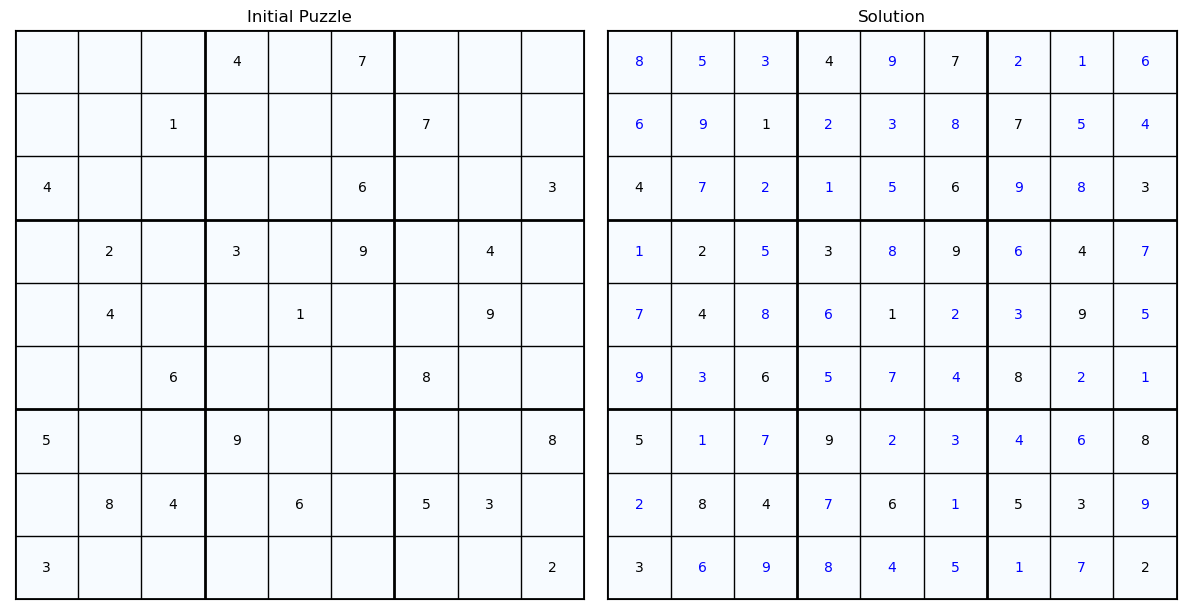

ModuleNotFoundError: No module named 'ace_tools'

In [9]:
import json
import pandas as pd
import os
from datetime import datetime
import math

# run the experiment
def run_experiment():
    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # get current timestamp
    print("Experiment Run At:", now)

    experiment_id = 'experiment_1'  # set experiment ID

    # load the Sudoku puzzles from the JSON file
    try:
        with open(f'./puzzles/{experiment_id}.json', 'r') as f:
            puzzles = json.load(f)  # load puzzles from file
    except FileNotFoundError:
        print(f"Error: The file ./puzzles/{experiment_id}.json does not exist.")
        return

    results = []  # list to store overall results

    # create output directory if it doesn't exist
    output_dir = f'./output/{experiment_id}/{now}/'
    os.makedirs(output_dir, exist_ok=True)  # create output directory

    # Iterate through each puzzle in the file
    for puzzle_id, puzzle in puzzles.items():
        succ_count = 0  # count of successful runs
        total_generations_in_all_runs = 0  # total generations for all runs
        # max_run = 100  # maximum number of runs in paper
        max_run = 1
        
        # create a list to store individual run results
        run_results = []

        print("#"*250)
        print("Puzzle ID: ", puzzle_id)
        
        for run_id in range(1, max_run + 1): 
            # different configurations for different difficulty levels of puzzles
            # lsga = LSGA(sudoku_puzzle=puzzle, experiment_id=experiment_id, puzzle_id=puzzle_id, run_id=run_id, output_folder=f"{output_dir}/{puzzle_id}/{run_id}", pop_size=200, elite_size=50, max_generations=1000, pc1=0.9, pc2=0.8, pm1=0.3, pm2=0.05, tournament_size=2) best for easy, medium
            # lsga = LSGA(sudoku_puzzle=puzzle, experiment_id=experiment_id, puzzle_id=puzzle_id, run_id=run_id, output_folder=f"{output_dir}/{puzzle_id}/{run_id}", pop_size=150, elite_size=40, max_generations=2000, pc1=0.8, pc2=0.75, pm1=0.35, pm2=0.055, tournament_size=2) best for hard1
            # lsga = LSGA(sudoku_puzzle=puzzle, experiment_id=experiment_id, puzzle_id=puzzle_id, run_id=run_id, output_folder=f"{output_dir}/{puzzle_id}/{run_id}", pop_size=200, elite_size=50, max_generations=10000, pc1=0.8, pc2=0.75, pm1=0.3, pm2=0.055, tournament_size=2) best for hard2

            lsga = LSGA(sudoku_puzzle=puzzle, experiment_id=experiment_id, puzzle_id=puzzle_id, run_id=run_id, output_folder=f"{output_dir}/{puzzle_id}/{run_id}", pop_size=200, elite_size=50, max_generations=2000, pc1=0.8, pc2=0.75, pm1=0.3, pm2=0.055, tournament_size=2) 

            # run the LSGA algorithm
            _, best_fitness, total_generations_to_find_solution = lsga.run()

            # check if the solution was found within the maximum generations
            if total_generations_to_find_solution < lsga.max_generations:
                succ_count += 1
            total_generations_in_all_runs += total_generations_to_find_solution

            # store each run result
            run_result = {
                'Run ID': run_id,
                'Best Fitness': best_fitness,
                'Generations to Solution': total_generations_to_find_solution
            }
            run_results.append(run_result)

            # save individual run results to Excel after each run
            run_results_df = pd.DataFrame(run_results)
            run_results_df.to_excel(f'{output_dir}/{puzzle_id}_runs.xlsx', index=False)

        # calculate average generations so far
        avg_generations = math.floor(total_generations_in_all_runs / max_run)
        temp_results = {'Puzzle ID': puzzle_id, 'Succ_Count': succ_count, 'Avg_Gen': avg_generations}
        results.append(temp_results)    

        # save overall results after each puzzle is processed  
        results_df = pd.DataFrame(results)
        results_df.to_excel(f'{output_dir}/results.xlsx', index=False) 

    # display results
    import ace_tools as tools
    tools.display_dataframe_to_user(name="LSGA Results", dataframe=results_df)

# run  experiment
run_experiment()
